In [1]:
# https://deep-learning-study.tistory.com/534
# https://github.com/pytorch/examples/blob/3970e068c7f18d2d54db2afee6ddd81ef3f93c24/imagenet/main.py#L171
# https://ai.dreamkkt.com/54
# https://github.com/BerenMillidge/PredictiveCodingBackprop
# https://github.com/nalonso2/PredictiveCoding-MQSeqIL/tree/main
# https://github.com/ptrblck/pytorch_misc/blob/master/batch_norm_manual.py

In [2]:
# https://eehoeskrap.tistory.com/430 : batch normalization
# https://jay-chamber.tistory.com/entry/torchTensor%EC%97%90-%EB%8C%80%ED%95%98%EC%97%AC : .grad, .is_leaf, retain_graph, requires_grad 등 설명
# https://darkpgmr.tistory.com/132 : Jacobian, Hessian 설명
# https://math.stackexchange.com/questions/3643354/difference-between-vjp-and-jvp : Vector-Jacobian Product 설명
# https://pytorch.org/docs/stable/generated/torch.autograd.functional.vjp.html : Vector-Jacobian Product 설명
# https://tutorials.pytorch.kr/intermediate/jacobians_hessians.html

# https://codingalone.tistory.com/2 : colab 시 커스텀 모듈 import 하는 법

In [1]:

import torch
import torchvision.datasets as dsets
# torchvision.datasets 을 이용해 ImageNet 데이터셋을 관리
import torchvision.transforms as transforms
# MNIST등의 데이터셋에 들어있는 데이터들을 원하는 모양으로 변환할때 사용하는 모듈

from torch import FloatTensor
from torch import optim
# from torch import FloatTensor, optim 같이 한줄로 합쳐도 됨 (as로 새이름 정하지 않을경우)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# 학습 진행이 느려지면 자동으로 lr값을 조정해주는 module

from torch.utils.data import DataLoader
# 미니배치 데이터 로딩을 도울 모듈

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import json
# n01443537 같이 되어있는 클래스 이름들을 goldfish 와 같이 쉽게 바꿔줄 때 사용할 파일이 JSON파일
import os
# os.path.join(save_path, filename) 으로 파일 경로 합칠 때 사용
import shutil
# shutil.copyfile(path_a, path_b) a 경로의 파일을 b 경로에 복사

import scipy


import torchsummary
# 모델 구조 표로 정리해서 보여주는 모듈
# torchsummary.summary(model, input_size=(3, 224, 224), batch_size=64) 와 같이 사용

from torchvision import models
# pretrained 된 모델들을 담고 있는 모듈

import torchvision.transforms.functional as visionF
# 이미지 표시에 쓰이는 visionF.to_pil_image(img) 함수등 여러 함수 포함

from torchvision.utils import make_grid
# 이미지들을 표시할 grid 생성


import time
import datetime
# 시간 측정에 사용

import math

import copy
# copy.deepcopy()로 깊은 복사 수행

In [2]:
from PCutils import *
from PCfunctions import *

from PClayers import *
from PCFCLayers import *
from PCConvLayers import *

from PCNets import *

In [3]:
USE_CUDA = torch.cuda.is_available() 
# GPU 사용가능하면 True 반환

device = torch.device('cuda' if USE_CUDA else 'cpu')
print(f"==>> device: {device}")

==>> device: cuda


In [6]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.247, 0.243, 0.262]),
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.247, 0.243, 0.262]),
])

# normalize 값 계산 : https://github.com/kuangliu/pytorch-cifar/issues/19

In [7]:
batch_size = 256

train_set = dsets.CIFAR10(root='../CIFAR10', train=True, download=True, transform=transform)
# train_set.data는 (50000, 32, 32, 3)꼴
# train_set.targets는 (50000,) 꼴

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

val_set = dsets.CIFAR10(root='../CIFAR10', train=False, download=True, transform=val_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)

print(len(train_loader.dataset))
print(len(val_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [8]:
# learning_rate = 0.0001
# testpcnet34 일때는 learning_rate가 엄청 작아야 한다
# (∵ BN이 없어서)
learning_rate = 0.01
# learning_rate = 0.001
# learning_rate = 0.0005

def pcsimplenet_256():
    return PCSimpleNet(learning_rate=learning_rate, momentum=0.1, device=device, n_iter_dx= 25, num_cnn_output_channel=256)

def pcresnet_256():
    return PCResNet2(PCResBlock2, [2,2,2,2], learning_rate, n_iter_dx=5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)
def pcresnet2_256():
    return PCResNet2(PCResBlock3, [2,2,2,2], learning_rate, n_iter_dx=5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)
def pcresnet_3463_256():
    return PCResNet2(PCResBlock2, [3,4,6,3], learning_rate, n_iter_dx=5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)


def pcdpnet_256():
    return PCResNet2(PCDPBlock, [3,4,6,3], learning_rate, n_iter_dx=5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)
def pcdpnet2_256():
    return PCResNet2(PCDPBlock2, [3,4,6,3], learning_rate, n_iter_dx=5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)
def pcdpnet2_small_256():
    return PCResNet2(PCDPBlock2, [2,2,2,2], learning_rate, n_iter_dx=5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)
def pcdpnet3_small_256():
    return PCResNet3(PCDPBlock3, [2,2,2,2], learning_rate, n_iter_dx=25, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)
def pcdpnet4_small_256():
    return PCResNet4(PCDPBlock4, [2,2,2,2], learning_rate, n_iter_dx=100, infer_rate=0.05, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)
def pcdpnet5_small_256():
    return PCResNet4(PCDPBlock4, [2,2,2,2], learning_rate, n_iter_dx=100, infer_rate=0.5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)

def pcshufflenet_256():
    return PCResNet2(PCShuffleV2Block, [3,4,6,3], learning_rate, n_iter_dx=5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)
def pcshufflenet_small_256():
    return PCResNet2(PCShuffleV2Block, [2,2,2,2], learning_rate, n_iter_dx=5, momentum=0.1, num_cnn_output_channel=256, num_classes=10, device=device)

In [9]:
# model = pcsimplenet_256()
# model = pcresnet_256()
# model = pcresnet_256()
# model = pcresnet_3463_256()
# model = pcdpnet_256()
# model = pcdpnet2_small_256()
# model = pcdpnet3_small_256()
# model = pcdpnet4_small_256()
model = pcdpnet5_small_256()
# model = pcdpnet2_256()
# model = pcshufflenet_256()
# model = pcshufflenet_small_256()

In [10]:
# torchsummary.summary(model, (3,32,32), batch_size)

In [11]:
# load_state = load_functions_table['resnet']

# state_load_file = '2023-10-29-15;19;03_epoch_14'
# state_load_path = os.path.join("../CIFAR10/data/", f'{state_load_file}.pth')
# load_state(model=model, load_path=state_load_path)


# date_load_file = '2023-10-29-15;19;03_history'
# load_path = os.path.join("../CIFAR10/data/", f'{date_load_file}.json')
# loss_history, acc_history, time_history, total_num_epochs = load_history(load_path=load_path)

In [12]:
loss_history = {'train':[], 'val':[]}
acc_history = {'train_top1':[], 'val_top1':[], 'train_top5':[], 'val_top5':[]}
time_history = []
total_num_epochs = 0

In [13]:
print(loss_history)
print(acc_history)
print(time_history)
print(total_num_epochs)

{'train': [], 'val': []}
{'train_top1': [], 'val_top1': [], 'train_top5': [], 'val_top5': []}
[]
0


In [14]:
# params_train = {
#     "num_epochs": 5,
#     "train_loader": train_loader,
#     "val_loader": val_loader,
#     "sanity_check": True,
#     # 모델 오류 확인 떄 sanity_check True로 두면 빠르게 확인 가능
#     "save_path": "../CIFAR10/data/",
#     "loss_history": loss_history,
#     "acc_history": acc_history,
#     "total_num_epochs": total_num_epochs,
#     "time_history": time_history
# }

In [15]:
params_train = {
    "num_epochs": 5,
    "train_loader": train_loader,
    "val_loader": val_loader,
    "sanity_check": False,
    # 모델 오류 확인 떄 sanity_check True로 두면 빠르게 확인 가능
    "save_path": "../CIFAR10/data/",
    "loss_history": loss_history,
    "acc_history": acc_history,
    "time_history": time_history,
    "total_num_epochs": total_num_epochs
}

In [16]:
# pcdpnet5_small_256
# batch_size 256
# learning_rate = 0.01
# infer_rate = 0.5
# infer 횟수 100


trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-29 21:32:57
--------------------------------------------------
2023-10-29 21:32:57
Epoch 0/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.44176225, train accuracy: (top1: 48.18%, top5: 90.40%)
elapsed time: 0:34:18
==>> len_data: 10000
val loss: 1.03937939, val accuracy: (top1: 63.11%, top5: 96.13%)
elapsed time: 0:00:02
 epoch elapsed time = 0:34:21
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-29 22:07:19
Epoch 1/4, current lr = 0.01
==>> len_data: 50000
train loss: 0.903335641, train accuracy: (top1: 68.26%, top5: 96.99%)
elapsed time: 0:33:53
==>> len_data: 10000
val loss: 0.832858787, val accuracy: (top1: 70.52%, top5: 97.60%)
elapsed time: 0:00:02
 epoch elapsed time = 0:33:55
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-29 22:41:15
Epoch 2/4, current lr = 0.01
==>> len_data: 50000
train loss: 0.73524515, train accuracy: (top1: 74.64%, top5: 98.01%)
elapsed time: 0:34:17
==>> len_data: 1

In [17]:
loss_history, acc_history, time_history = loss_hist, acc_hist, time_hist
total_num_epochs = 5

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-30 00:23:42
--------------------------------------------------
2023-10-30 00:23:42
Epoch 0/4, current lr = 0.01
==>> len_data: 50000
train loss: 0.523661237, train accuracy: (top1: 82.11%, top5: 98.88%)
elapsed time: 0:33:55
==>> len_data: 10000
val loss: 0.57263862, val accuracy: (top1: 80.38%, top5: 98.88%)
elapsed time: 0:00:02
 epoch elapsed time = 0:33:58
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-30 00:57:40
Epoch 1/4, current lr = 0.01
==>> len_data: 50000
train loss: 0.488693292, train accuracy: (top1: 83.34%, top5: 98.96%)
elapsed time: 0:33:31
==>> len_data: 10000
val loss: 0.606676495, val accuracy: (top1: 79.78%, top5: 98.65%)
elapsed time: 0:00:02
 epoch elapsed time = 0:33:33
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-30 01:31:14
Epoch 2/4, current lr = 0.01
==>> len_data: 50000
train loss: 0.460046997, train accuracy: (top1: 84.28%, top5: 99.04%)
elapsed time: 0:33:33
==>> len_data:

In [18]:
loss_history, acc_history, time_history = loss_hist, acc_hist, time_hist
total_num_epochs = 10

model.set_lr(0.001)
for param_group in model.fc.optim.param_groups:
    param_group["lr"] = 0.001
model.fc.lr_scheduler = ReduceLROnPlateau(model.fc.optim, mode="min", factor=0.1, patience=5)

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-30 03:12:07
--------------------------------------------------
2023-10-30 03:12:07
Epoch 0/4, current lr = 0.001
==>> len_data: 50000
train loss: 0.327806775, train accuracy: (top1: 89.42%, top5: 99.26%)
elapsed time: 0:33:31
==>> len_data: 10000
val loss: 0.429067777, val accuracy: (top1: 85.73%, top5: 99.25%)
elapsed time: 0:00:02
 epoch elapsed time = 0:33:33
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-30 03:45:41
Epoch 1/4, current lr = 0.001
==>> len_data: 50000
train loss: 0.297457613, train accuracy: (top1: 90.64%, top5: 99.33%)
elapsed time: 0:33:31
==>> len_data: 10000
val loss: 0.406956809, val accuracy: (top1: 86.28%, top5: 99.33%)
elapsed time: 0:00:02
 epoch elapsed time = 0:33:33
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-30 04:19:15
Epoch 2/4, current lr = 0.001
==>> len_data: 50000
train loss: 0.286649421, train accuracy: (top1: 91.05%, top5: 99.36%)
elapsed time: 0:33:30
==>> len_d

In [19]:
loss_history, acc_history, time_history = loss_hist, acc_hist, time_hist
total_num_epochs = 15

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-30 05:59:56
--------------------------------------------------
2023-10-30 05:59:56
Epoch 0/4, current lr = 0.001
==>> len_data: 50000
train loss: 0.260993512, train accuracy: (top1: 92.16%, top5: 99.40%)
elapsed time: 0:33:30
==>> len_data: 10000
val loss: 0.41158617, val accuracy: (top1: 86.30%, top5: 99.43%)
elapsed time: 0:00:02
 epoch elapsed time = 0:33:33
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-30 06:33:29
Epoch 1/4, current lr = 0.001
==>> len_data: 50000
train loss: 0.255593149, train accuracy: (top1: 92.40%, top5: 99.38%)
elapsed time: 0:34:45
==>> len_data: 10000
val loss: 0.407357696, val accuracy: (top1: 86.71%, top5: 99.41%)
elapsed time: 0:00:02
 epoch elapsed time = 0:34:47
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-30 07:08:17
Epoch 2/4, current lr = 0.001
==>> len_data: 50000
train loss: 0.250486334, train accuracy: (top1: 92.68%, top5: 99.39%)
elapsed time: 0:34:52
==>> len_da

In [20]:
loss_history, acc_history, time_history = loss_hist, acc_hist, time_hist
params_train = {
    "num_epochs": 5,
    "train_loader": train_loader,
    "val_loader": val_loader,
    "sanity_check": False,
    # 모델 오류 확인 떄 sanity_check True로 두면 빠르게 확인 가능
    "save_path": "../CIFAR10/data/",
    "loss_history": loss_history,
    "acc_history": acc_history,
    "time_history": time_history,
    "total_num_epochs": 20,
}

model.set_lr(0.0001)
for param_group in model.fc.optim.param_groups:
    param_group["lr"] = 0.0001
model.fc.lr_scheduler = ReduceLROnPlateau(model.fc.optim, mode="min", factor=0.1, patience=5)

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-30 08:52:19
--------------------------------------------------
2023-10-30 08:52:19
Epoch 0/4, current lr = 0.0001
==>> len_data: 50000
train loss: 0.227543409, train accuracy: (top1: 93.65%, top5: 99.42%)
elapsed time: 0:34:55
==>> len_data: 10000
val loss: 0.405261363, val accuracy: (top1: 86.53%, top5: 99.43%)
elapsed time: 0:00:02
 epoch elapsed time = 0:34:57
==>> total_num_epochs: 21
--------------------------------------------------
2023-10-30 09:27:17
Epoch 1/4, current lr = 0.0001
==>> len_data: 50000
train loss: 0.226382068, train accuracy: (top1: 93.83%, top5: 99.41%)
elapsed time: 0:34:23
==>> len_data: 10000
val loss: 0.408032697, val accuracy: (top1: 86.62%, top5: 99.42%)
elapsed time: 0:00:02
 epoch elapsed time = 0:34:26
==>> total_num_epochs: 22
--------------------------------------------------
2023-10-30 10:01:43
Epoch 2/4, current lr = 0.0001
==>> len_data: 50000
train loss: 0.225661762, train accuracy: (top1: 93.81%, top5: 99.43%)
elapsed time: 0:34:47
==>> 

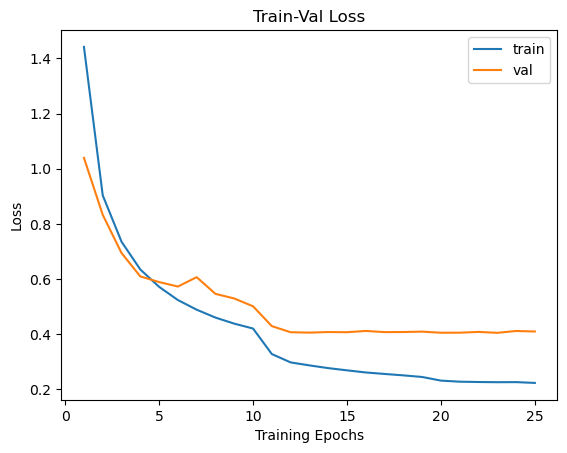

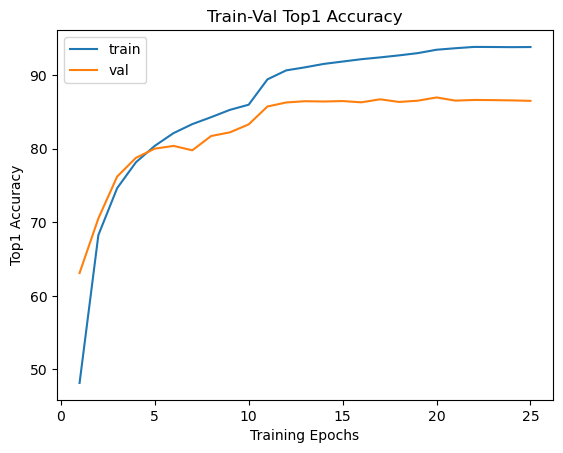

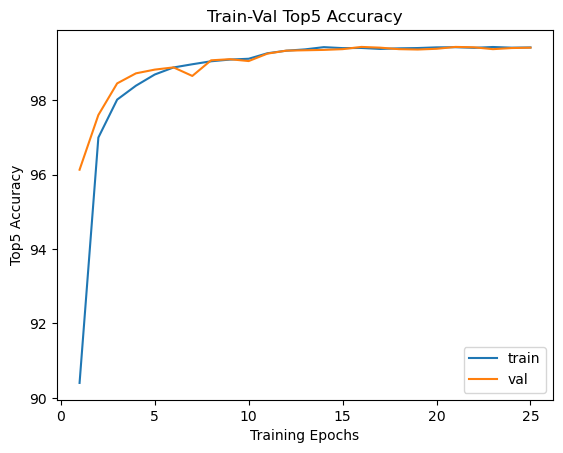

In [21]:
# pcdpnet5_small_256
# batch_size 256
# learning_rate = 0.01
# infer_rate = 0.5
# infer 횟수 100

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [22]:
torchsummary.summary(model, (3,32,32), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 16, 32, 32]             432
       BatchNorm2d-2          [256, 16, 32, 32]              32
              ReLU-3          [256, 16, 32, 32]               0
            ConvAG-4          [256, 16, 32, 32]               0
         AvgPool2d-5          [256, 16, 32, 32]               0
      AvgPoolLayer-6          [256, 16, 32, 32]               0
            Conv2d-7          [256, 32, 32, 32]             288
            DPConv-8          [256, 16, 32, 32]               0
       BatchNorm2d-9          [256, 16, 32, 32]              32
             ReLU-10          [256, 16, 32, 32]               0
           Conv2d-11          [256, 16, 32, 32]             272
           Conv2d-12          [256, 32, 32, 32]             288
           DPConv-13          [256, 16, 32, 32]               0
      BatchNorm2d-14          [256, 16,

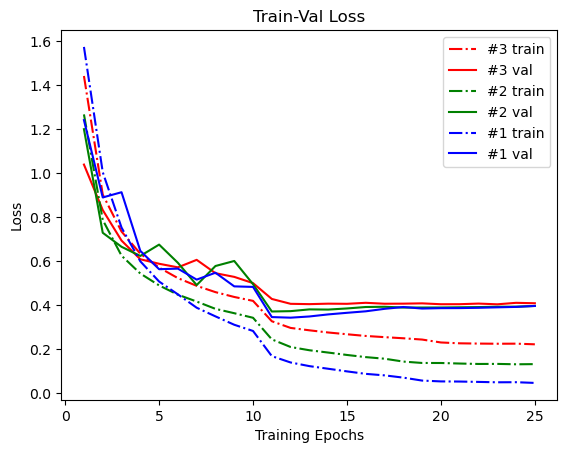

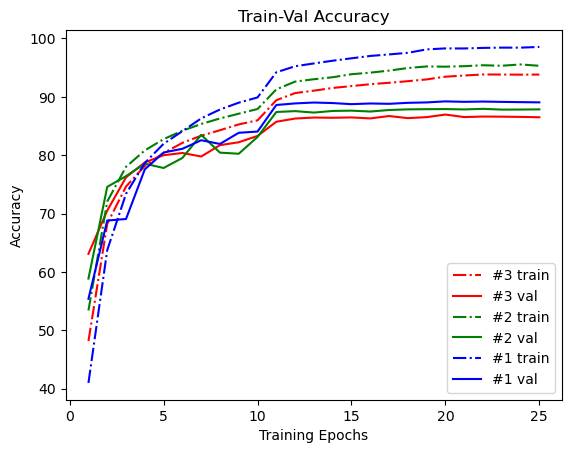

In [6]:
# 모델 3개 비교

date_load_file = '2023-10-30-11;44;35_history'
load_path = os.path.join("../CIFAR10/data/", f'{date_load_file}.json')
loss_history, acc_history, time_history, total_num_epochs = load_history(load_path=load_path)

date_load_file = 'BP_2023-10-30-12;07;47_history'
load_path = os.path.join("../CIFAR10/data/", f'{date_load_file}.json')
loss_history2, acc_history2, time_history2, total_num_epochs2 = load_history(load_path=load_path)

date_load_file = 'BP_2023-10-30-12;19;33_history'
load_path = os.path.join("../CIFAR10/data/", f'{date_load_file}.json')
loss_history3, acc_history3, time_history3, total_num_epochs3 = load_history(load_path=load_path)

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_history["train"], '-.r', label="#3 train")
plt.plot(range(1,total_num_epochs+1),loss_history["val"] , 'r', label="#3 val")
plt.plot(range(1,total_num_epochs+1),loss_history2["train"], '-.g', label="#2 train")
plt.plot(range(1,total_num_epochs+1),loss_history2["val"], 'g', label="#2 val")
plt.plot(range(1,total_num_epochs+1),loss_history3["train"], '-.b', label="#1 train")
plt.plot(range(1,total_num_epochs+1),loss_history3["val"], 'b', label="#1 val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_history["train_top1"], '-.r', label="#3 train")
plt.plot(range(1,total_num_epochs+1),acc_history["val_top1"], 'r', label="#3 val")
plt.plot(range(1,total_num_epochs+1),acc_history2["train_top1"], '-.g', label="#2 train")
plt.plot(range(1,total_num_epochs+1),acc_history2["val_top1"], 'g', label="#2 val")
plt.plot(range(1,total_num_epochs+1),acc_history3["train_top1"], '-.b', label="#1 train")
plt.plot(range(1,total_num_epochs+1),acc_history3["val_top1"], 'b', label="#1 val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()



In [ ]:
loss_history, acc_history, time_history = loss_hist, acc_hist, time_hist

model.set_lr(0.00001)
for param_group in model.fc.optim.param_groups:
    param_group["lr"] = 0.00001
model.fc.lr_scheduler = ReduceLROnPlateau(model.fc.optim, mode="min", factor=0.1, patience=5)

params_train = {
    "num_epochs": 5,
    "train_loader": train_loader,
    "val_loader": val_loader,
    "sanity_check": False,
    # 모델 오류 확인 떄 sanity_check True로 두면 빠르게 확인 가능
    "save_path": "../CIFAR10/data/",
    "loss_history": loss_history,
    "acc_history": acc_history,
    "time_history": time_history,
    "total_num_epochs": 25,
}

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

In [16]:
# pcdpnet4_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# decay 제거
# infer 횟수 100


trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-29 17:48:08
--------------------------------------------------
2023-10-29 17:48:08
Epoch 0/9, current lr = 0.0005
==>> len_data: 50000
train loss: 1.68292965, train accuracy: (top1: 38.40%, top5: 86.82%)
elapsed time: 0:34:39
==>> len_data: 10000
val loss: 1.484706, val accuracy: (top1: 45.55%, top5: 91.94%)
elapsed time: 0:00:02
 epoch elapsed time = 0:34:42
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-29 18:22:50
Epoch 1/9, current lr = 0.0005
==>> len_data: 50000
train loss: 1.41026383, train accuracy: (top1: 49.06%, top5: 92.46%)
elapsed time: 0:34:40
==>> len_data: 10000
val loss: 1.36212932, val accuracy: (top1: 51.44%, top5: 93.18%)
elapsed time: 0:00:02
 epoch elapsed time = 0:34:43
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-29 18:57:34
Epoch 2/9, current lr = 0.0005
==>> len_data: 50000
train loss: 1.33556279, train accuracy: (top1: 52.05%, top5: 93.18%)
elapsed time: 0:34:34
==>> len_data:

KeyboardInterrupt: 

In [ ]:
# pcdpnet4_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# decay 제거
# infer 횟수 100

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [14]:
# pcdpnet4_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# decay 제거
# infer 횟수 10


trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-29 15:23:20
--------------------------------------------------
2023-10-29 15:23:20
Epoch 0/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.45310825, train accuracy: (top1: 48.09%, top5: 91.82%)
elapsed time: 0:04:03
==>> len_data: 10000
val loss: 1.45947125, val accuracy: (top1: 48.44%, top5: 91.80%)
elapsed time: 0:00:02
 epoch elapsed time = 0:04:06
==>> total_num_epochs: 16
--------------------------------------------------
2023-10-29 15:27:26
Epoch 1/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.44248506, train accuracy: (top1: 48.56%, top5: 91.83%)
elapsed time: 0:03:55
==>> len_data: 10000
val loss: 1.43262454, val accuracy: (top1: 48.73%, top5: 92.35%)
elapsed time: 0:00:02
 epoch elapsed time = 0:03:57
==>> total_num_epochs: 17
--------------------------------------------------
2023-10-29 15:31:24
Epoch 2/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.44198048, train accuracy: (top1: 48.26%, top5: 91.87%)
elapsed time: 0:03:53
==>> le

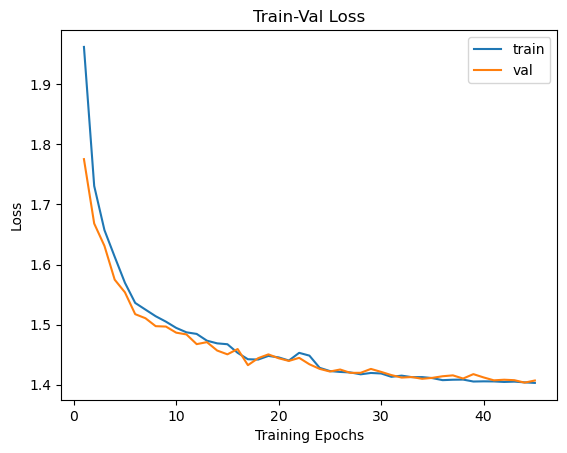

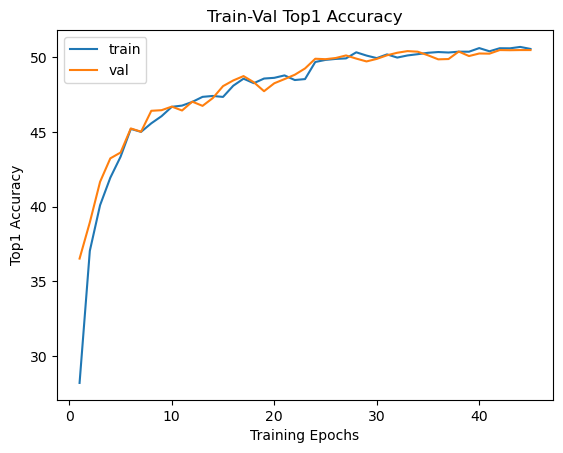

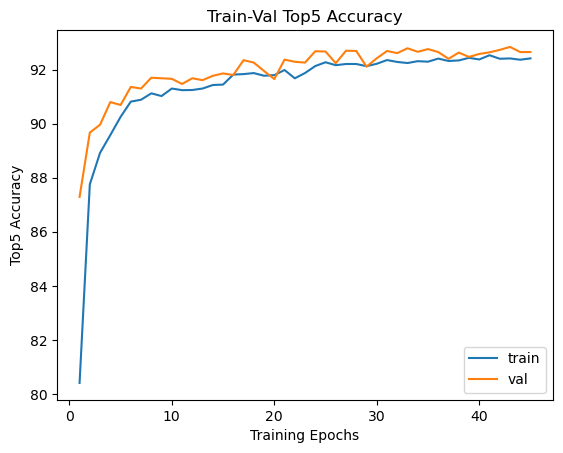

In [15]:
# pcdpnet4_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# decay 제거
# infer 횟수 10

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcdpnet4_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# decay 제거
# infer 횟수 10

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-29 14:18:48
--------------------------------------------------
2023-10-29 14:18:48
Epoch 0/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.96210409, train accuracy: (top1: 28.22%, top5: 80.41%)
elapsed time: 0:04:02
==>> len_data: 10000
val loss: 1.77543105, val accuracy: (top1: 36.53%, top5: 87.29%)
elapsed time: 0:00:02
 epoch elapsed time = 0:04:05
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-29 14:22:53
Epoch 1/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.73077444, train accuracy: (top1: 37.05%, top5: 87.75%)
elapsed time: 0:03:55
==>> len_data: 10000
val loss: 1.6682843, val accuracy: (top1: 38.95%, top5: 89.67%)
elapsed time: 0:00:02
 epoch elapsed time = 0:03:58
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-29 14:26:52
Epoch 2/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.65735773, train accuracy: (top1: 40.10%, top5: 88.92%)
elapsed time: 0:03:53
==>> len_d

KeyboardInterrupt: 

In [16]:
# pcdpnet4_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# decay 제거
# infer 횟수 50

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-29 12:44:01
--------------------------------------------------
2023-10-29 12:44:01
Epoch 0/4, current lr = 0.0005
==>> len_data: 50000
train loss: 1.7566278, train accuracy: (top1: 36.03%, top5: 85.40%)
elapsed time: 0:17:44
==>> len_data: 10000
val loss: 1.5424499, val accuracy: (top1: 43.90%, top5: 90.50%)
elapsed time: 0:00:02
 epoch elapsed time = 0:17:47
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-29 13:01:48
Epoch 1/4, current lr = 0.0005
==>> len_data: 50000
train loss: 1.49754394, train accuracy: (top1: 45.62%, top5: 91.12%)
elapsed time: 0:17:56
==>> len_data: 10000
val loss: 1.46289072, val accuracy: (top1: 46.80%, top5: 92.01%)
elapsed time: 0:00:02
 epoch elapsed time = 0:17:59
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-29 13:19:48
Epoch 2/4, current lr = 0.0005
==>> len_data: 50000
train loss: 1.42405808, train accuracy: (top1: 48.73%, top5: 92.18%)
elapsed time: 0:18:04
==>> len_data:

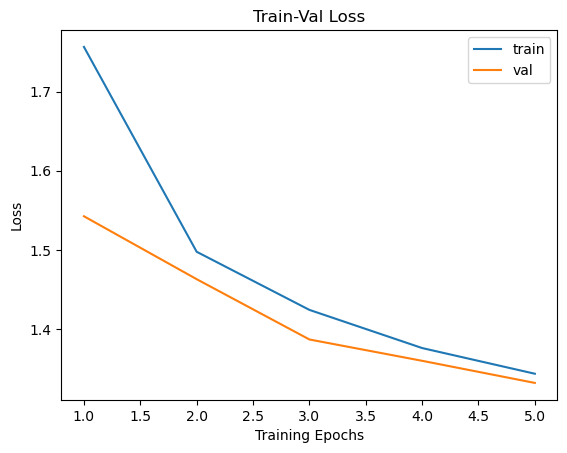

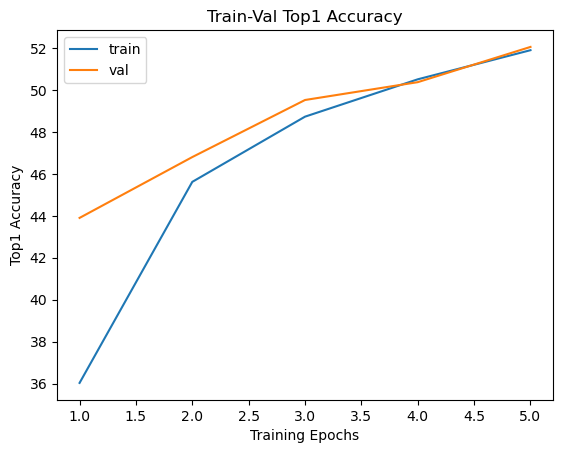

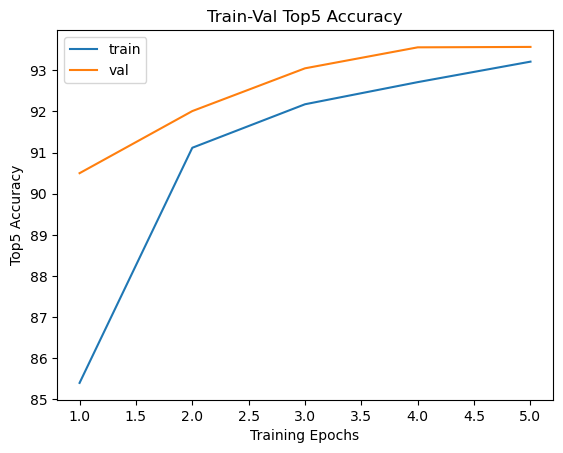

In [17]:
# pcdpnet4_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# decay 제거
# infer 횟수 50

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcdpnet3_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-29 10:35:12
--------------------------------------------------
2023-10-29 10:35:12
Epoch 0/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.99548782, train accuracy: (top1: 27.66%, top5: 80.36%)
elapsed time: 0:08:42
==>> len_data: 10000
val loss: 1.86058375, val accuracy: (top1: 34.24%, top5: 85.70%)
elapsed time: 0:00:02
 epoch elapsed time = 0:08:45
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-29 10:43:58
Epoch 1/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.81456847, train accuracy: (top1: 34.29%, top5: 85.58%)
elapsed time: 0:08:30
==>> len_data: 10000
val loss: 1.76509157, val accuracy: (top1: 36.49%, top5: 87.34%)
elapsed time: 0:00:02
 epoch elapsed time = 0:08:33
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-29 10:52:31
Epoch 2/29, current lr = 0.0005
==>> len_data: 50000
train loss: 1.76487285, train accuracy: (top1: 36.04%, top5: 86.77%)
elapsed time: 0:08:26
==>> len_

KeyboardInterrupt: 

In [ ]:
# pcdpnet3_small_256
# batch_size 128
# learning_rate = 0.0005
# shortcut pass dfdt 계산
# infer 과정 SeqIL 미적용
# infer 횟수 25

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcdpnet2_small_256
# batch_size 128
# learning_rate = 0.001
# shortcut pass dfdt 계산
# infer 횟수 5

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train, m_name="resnet")

2023-10-29 01:53:52
--------------------------------------------------
2023-10-29 01:53:52
Epoch 0/59, current lr = 0.001
==>> len_data: 50000
train loss: 2.00446002, train accuracy: (top1: 27.06%, top5: 77.76%)
elapsed time: 0:02:15
==>> len_data: 10000
val loss: 1.85559805, val accuracy: (top1: 35.10%, top5: 84.15%)
elapsed time: 0:00:02
 epoch elapsed time = 0:02:18
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-29 01:56:10
Epoch 1/59, current lr = 0.001
==>> len_data: 50000
train loss: 1.79877719, train accuracy: (top1: 34.93%, top5: 85.52%)
elapsed time: 0:02:13
==>> len_data: 10000
val loss: 1.74430207, val accuracy: (top1: 36.81%, top5: 87.65%)
elapsed time: 0:00:02
 epoch elapsed time = 0:02:16
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-29 01:58:27
Epoch 2/59, current lr = 0.001
==>> len_data: 50000
train loss: 1.72188913, train accuracy: (top1: 37.22%, top5: 87.21%)
elapsed time: 0:02:12
==>> len_dat

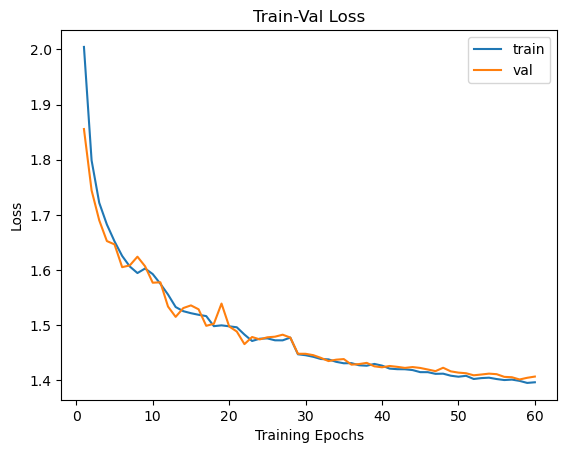

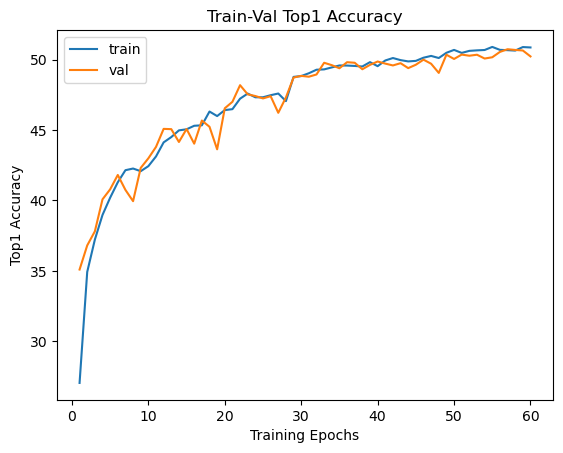

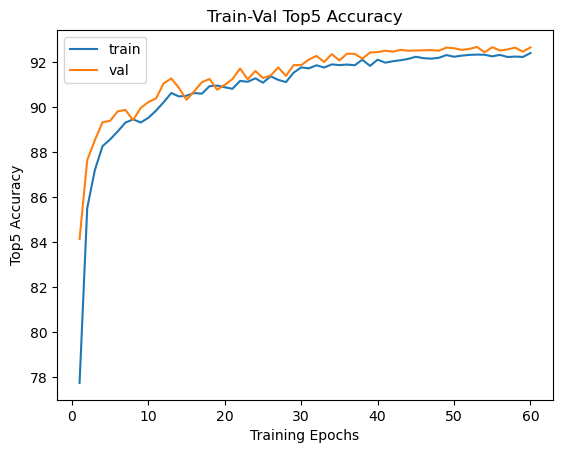

In [17]:
# pcdpnet2_small_256
# batch_size 128
# learning_rate = 0.001
# shortcut pass dfdt 계산
# infer 횟수 5

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcdpnet2_256
# batch_size 128
# learning_rate = 0.0001
# shortcut pass dfdt 계산
# infer 횟수 5

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-28 21:05:25
--------------------------------------------------
2023-10-28 21:05:25
Epoch 0/49, current lr = 0.0001
==>> len_data: 50000
train loss: 2.25194019, train accuracy: (top1: 16.48%, top5: 63.56%)
elapsed time: 0:04:46
==>> len_data: 10000
val loss: 2.21755207, val accuracy: (top1: 20.32%, top5: 68.64%)
elapsed time: 0:00:04
 epoch elapsed time = 0:04:50
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-28 21:10:15
Epoch 1/49, current lr = 0.0001
==>> len_data: 50000
train loss: 2.19055281, train accuracy: (top1: 21.28%, top5: 69.95%)
elapsed time: 0:04:43
==>> len_data: 10000
val loss: 2.16531347, val accuracy: (top1: 23.55%, top5: 71.54%)
elapsed time: 0:00:04
 epoch elapsed time = 0:04:48
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-28 21:15:03
Epoch 2/49, current lr = 0.0001
==>> len_data: 50000
train loss: 2.14443348, train accuracy: (top1: 23.10%, top5: 73.06%)
elapsed time: 0:04:39
==>> len_

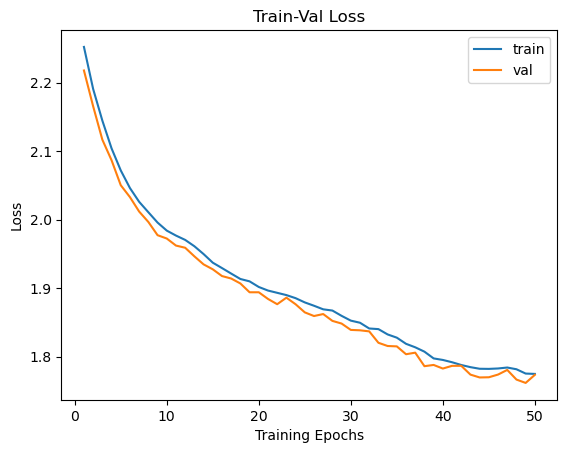

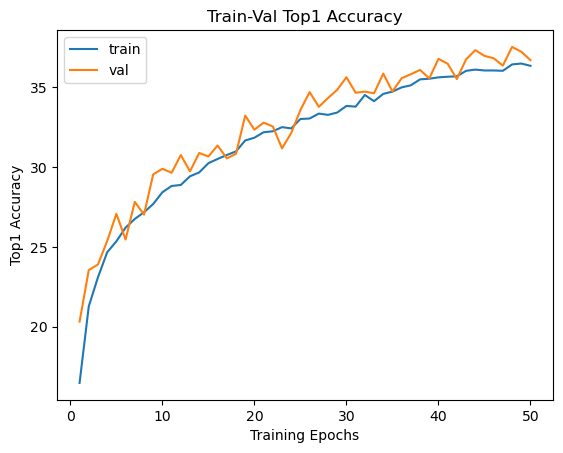

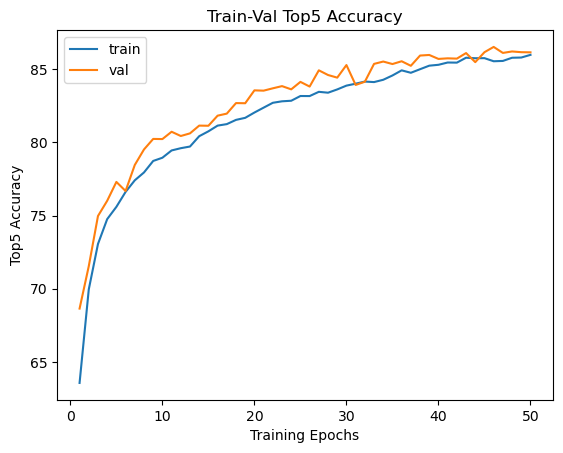

In [17]:
# pcdpnet2_256
# batch_size 128
# learning_rate = 0.0001
# shortcut pass dfdt 계산
# infer 횟수 5

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [18]:
# pcresnet_256
# batch_size 64
# shortcut pass dfdt 계산 안함
# infer 횟수 5

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-28 20:03:31
--------------------------------------------------
2023-10-28 20:03:31
Epoch 0/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.00094117, train accuracy: (top1: 28.29%, top5: 79.66%)
elapsed time: 0:01:46
==>> len_data: 10000
val loss: 1.78625229, val accuracy: (top1: 36.57%, top5: 85.82%)
elapsed time: 0:00:02
 epoch elapsed time = 0:01:49
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-28 20:05:21
Epoch 1/29, current lr = 0.01
==>> len_data: 50000
train loss: 1.79408815, train accuracy: (top1: 36.22%, top5: 85.87%)
elapsed time: 0:01:45
==>> len_data: 10000
val loss: 1.63915424, val accuracy: (top1: 42.09%, top5: 88.22%)
elapsed time: 0:00:02
 epoch elapsed time = 0:01:48
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-28 20:07:09
Epoch 2/29, current lr = 0.01
==>> len_data: 50000
train loss: 1.72107347, train accuracy: (top1: 39.47%, top5: 87.53%)
elapsed time: 0:01:45
==>> len_data: 

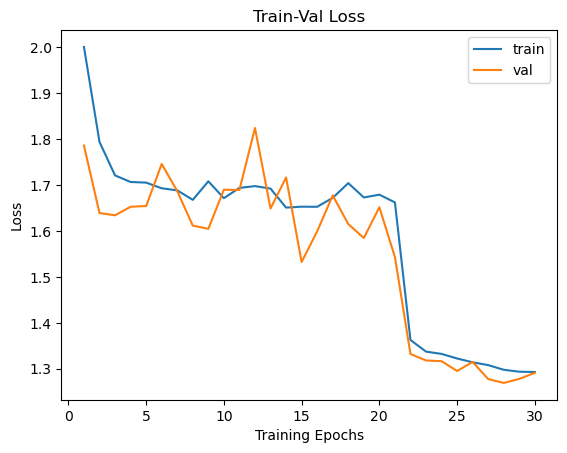

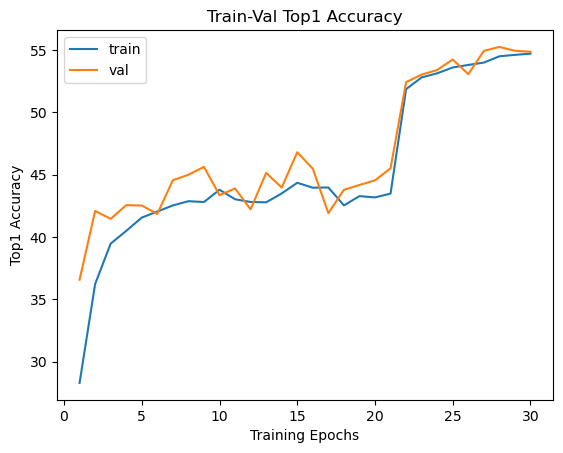

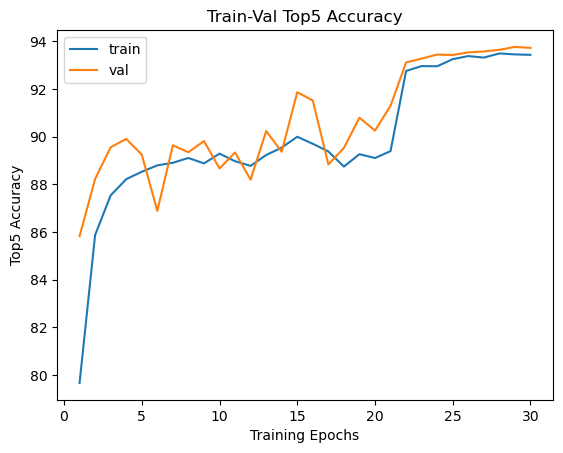

In [19]:
# pcresnet_256
# batch_size 64
# shortcut pass dfdt 계산 안함
# infer 횟수 5

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcresnet_256
# batch_size 32
# shortcut pass dfdt 계산
# infer 횟수 10

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-28 17:49:09
--------------------------------------------------
2023-10-28 17:49:09
Epoch 0/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.06592048, train accuracy: (top1: 26.80%, top5: 79.27%)
elapsed time: 0:04:19
==>> len_data: 10000
val loss: 2.0879801, val accuracy: (top1: 26.06%, top5: 83.14%)
elapsed time: 0:00:03
 epoch elapsed time = 0:04:22
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-28 17:53:32
Epoch 1/29, current lr = 0.01
==>> len_data: 50000
train loss: 1.97811631, train accuracy: (top1: 31.30%, top5: 82.63%)
elapsed time: 0:04:14
==>> len_data: 10000
val loss: 1.8603646, val accuracy: (top1: 34.99%, top5: 86.21%)
elapsed time: 0:00:02
 epoch elapsed time = 0:04:17
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-28 17:57:50
Epoch 2/29, current lr = 0.01
==>> len_data: 50000
train loss: 1.90282539, train accuracy: (top1: 34.09%, top5: 84.51%)
elapsed time: 0:04:18
==>> len_data: 10

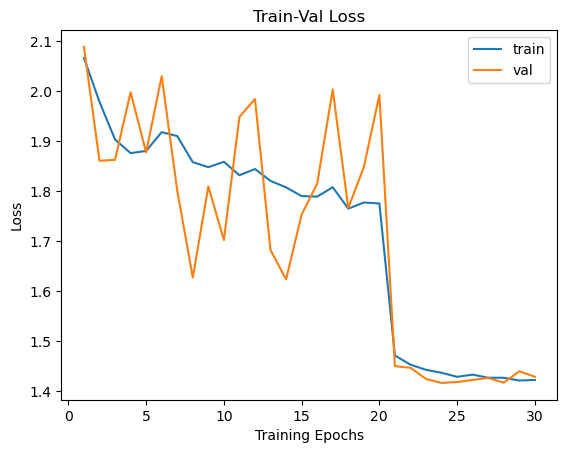

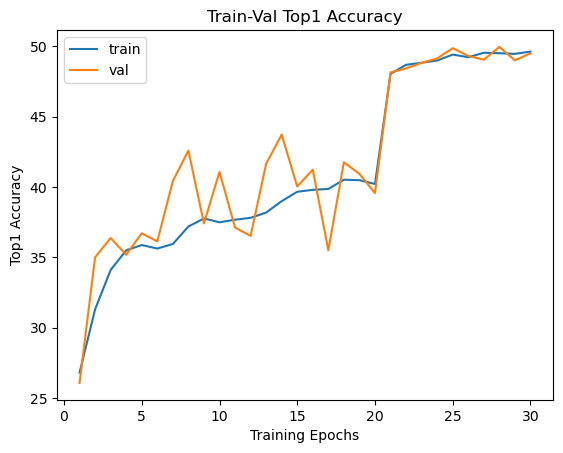

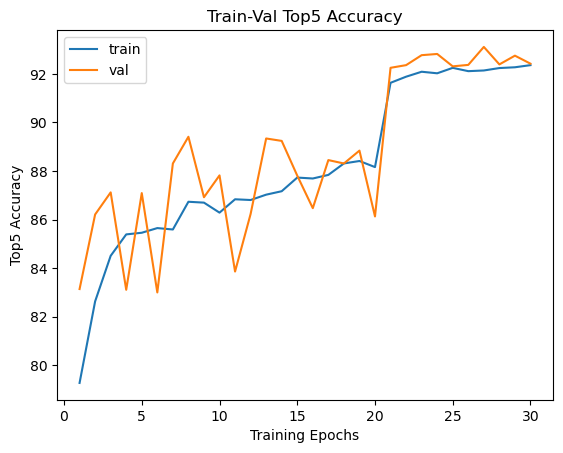

In [17]:
# pcresnet_256
# batch_size 32
# shortcut pass dfdt 계산
# infer 횟수 10

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcresnet_256
# batch_size 32
# shortcut pass dfdt 계산 안함
# infer 횟수 10

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-28 15:58:37
--------------------------------------------------
2023-10-28 15:58:37
Epoch 0/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.0605503, train accuracy: (top1: 27.56%, top5: 79.31%)
elapsed time: 0:03:20
==>> len_data: 10000
val loss: 2.08373825, val accuracy: (top1: 32.16%, top5: 79.72%)
elapsed time: 0:00:03
 epoch elapsed time = 0:03:23
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-28 16:02:01
Epoch 1/29, current lr = 0.01
==>> len_data: 50000
train loss: 1.93019305, train accuracy: (top1: 33.42%, top5: 84.17%)
elapsed time: 0:03:16
==>> len_data: 10000
val loss: 1.97393761, val accuracy: (top1: 34.46%, top5: 83.04%)
elapsed time: 0:00:02
 epoch elapsed time = 0:03:19
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-28 16:05:20
Epoch 2/29, current lr = 0.01
==>> len_data: 50000
train loss: 1.88518259, train accuracy: (top1: 35.95%, top5: 85.59%)
elapsed time: 0:03:13
==>> len_data: 1

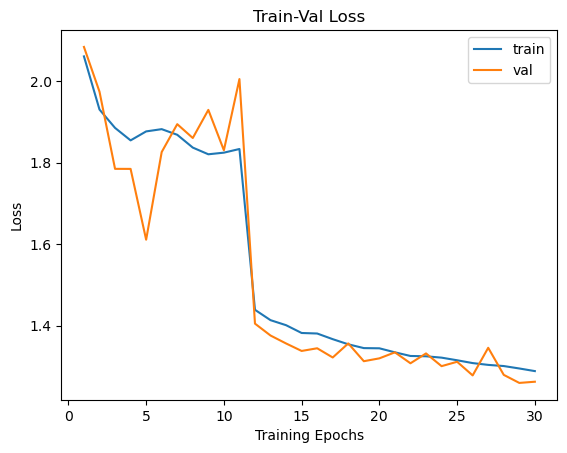

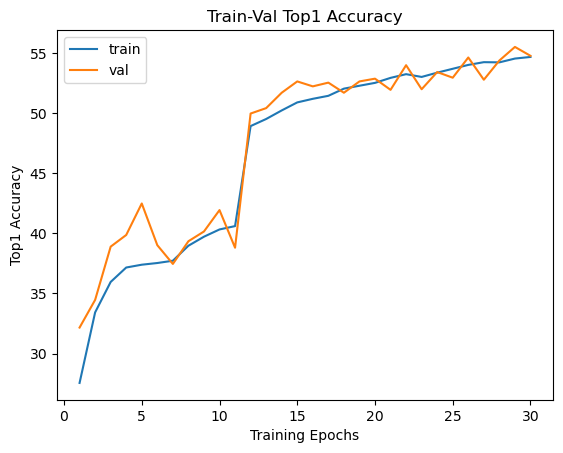

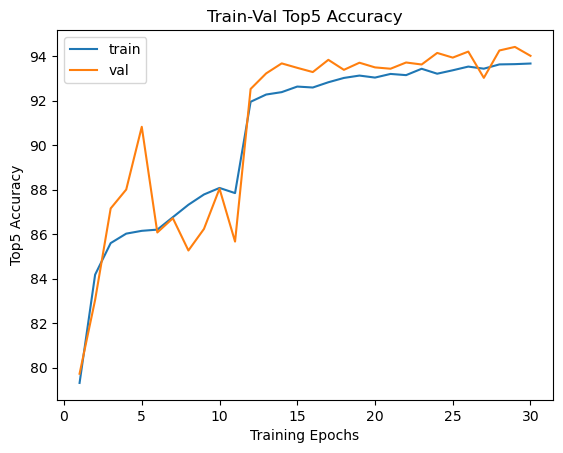

In [17]:
# pcresnet_256
# batch_size 32
# shortcut pass dfdt 계산 안함
# infer 횟수 10

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcresnet_3463_256
# batch_size 32
# shortcut pass dfdt 계산 안함
# infer 횟수 10

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-28 12:25:49
--------------------------------------------------
2023-10-28 12:25:49
Epoch 0/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.50959274, train accuracy: (top1: 19.66%, top5: 69.59%)
elapsed time: 0:07:03
==>> len_data: 10000
val loss: 2.97516467, val accuracy: (top1: 20.24%, top5: 70.99%)
elapsed time: 0:00:04
 epoch elapsed time = 0:07:08
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-28 12:32:58
Epoch 1/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.41501351, train accuracy: (top1: 23.40%, top5: 75.41%)
elapsed time: 0:07:05
==>> len_data: 10000
val loss: 2.25770011, val accuracy: (top1: 24.78%, top5: 78.10%)
elapsed time: 0:00:04
 epoch elapsed time = 0:07:09
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-28 12:40:08
Epoch 2/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.45007626, train accuracy: (top1: 24.37%, top5: 76.19%)
elapsed time: 0:07:09
==>> len_data: 

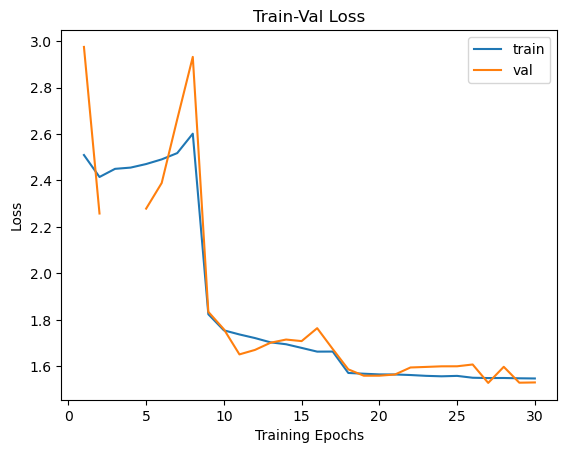

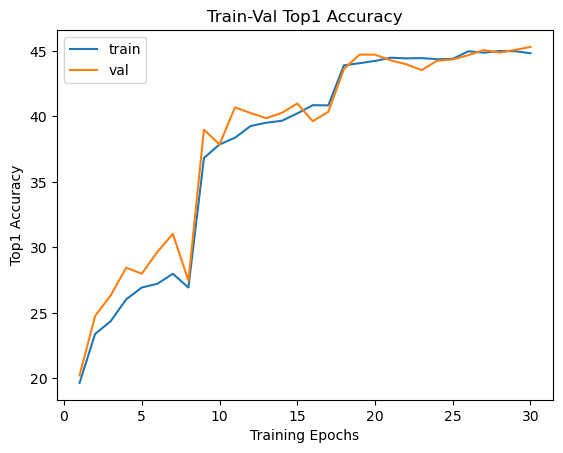

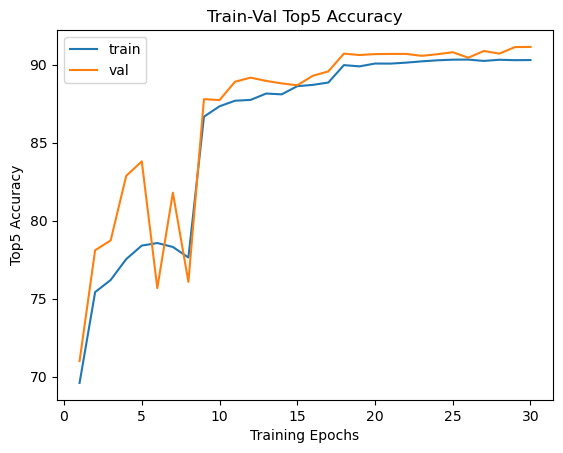

In [17]:
# pcresnet_3463_256
# batch_size 32
# shortcut pass dfdt 계산 안함
# infer 횟수 10

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcdpnet2_256
# batch_size 32
# shortcut pass dfdt 계산
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-28 10:53:37
--------------------------------------------------
2023-10-28 10:53:37
Epoch 0/29, current lr = 0.001
==>> len_data: 50000
train loss: 2.10961218, train accuracy: (top1: 21.97%, top5: 72.74%)
elapsed time: 0:21:12
==>> len_data: 10000
val loss: 2.05586016, val accuracy: (top1: 27.16%, top5: 76.85%)
elapsed time: 0:00:04
 epoch elapsed time = 0:21:16
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-28 11:14:54
Epoch 1/29, current lr = 0.001
==>> len_data: 50000
train loss: 1.97605107, train accuracy: (top1: 27.11%, top5: 79.63%)
elapsed time: 0:21:04
==>> len_data: 10000
val loss: 1.92436742, val accuracy: (top1: 28.19%, top5: 82.84%)
elapsed time: 0:00:04
 epoch elapsed time = 0:21:09
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-28 11:36:03
Epoch 2/29, current lr = 0.001
==>> len_data: 50000
train loss: 1.94614748, train accuracy: (top1: 28.67%, top5: 80.54%)
elapsed time: 0:21:06
==>> len_dat

KeyboardInterrupt: 

In [16]:
# pcdpnet_256
# batch_size 32
# shortcut pass dfdt 계산 안함
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-28 00:49:49
--------------------------------------------------
2023-10-28 00:49:49
Epoch 0/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.56242948, train accuracy: (top1: 19.15%, top5: 66.39%)
elapsed time: 0:17:02
==>> len_data: 10000
val loss: 2.81548764, val accuracy: (top1: 22.59%, top5: 65.84%)
elapsed time: 0:00:04
 epoch elapsed time = 0:17:06
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-28 01:06:56
Epoch 1/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.53785396, train accuracy: (top1: 21.50%, top5: 69.54%)
elapsed time: 0:16:54
==>> len_data: 10000
val loss: 2.27387195, val accuracy: (top1: 23.89%, top5: 72.18%)
elapsed time: 0:00:04
 epoch elapsed time = 0:16:58
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-28 01:23:55
Epoch 2/29, current lr = 0.01
==>> len_data: 50000
train loss: 2.51322079, train accuracy: (top1: 22.78%, top5: 72.30%)
elapsed time: 0:16:47
==>> len_data: 

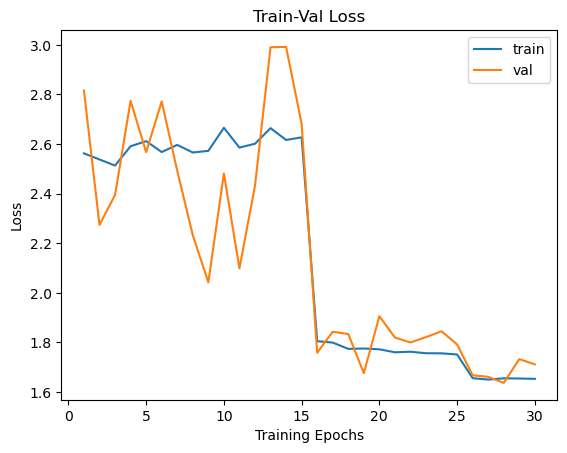

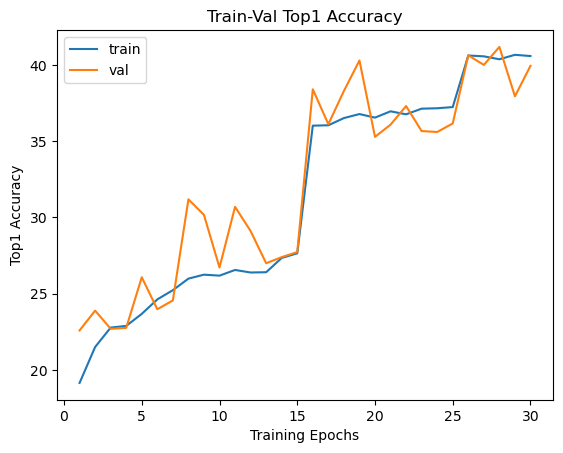

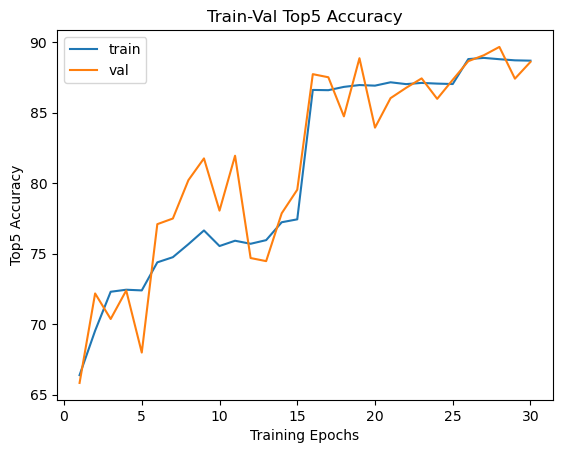

In [17]:
# pcdpnet_256
# batch_size 32
# shortcut pass dfdt 계산 안함
# infer 횟수 25

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [16]:
# pcresnet_256
# ‘fixed prediction assumption’
# shortcut pass도 dfdt 계산
# batch_size 32
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-27 22:07:05
--------------------------------------------------
2023-10-27 22:07:05
Epoch 0/4, current lr = 0.01
==>> len_data: 50000
train loss: 2.08254467, train accuracy: (top1: 26.99%, top5: 78.60%)
elapsed time: 0:07:12
==>> len_data: 10000
val loss: 1.85049625, val accuracy: (top1: 33.28%, top5: 84.81%)
elapsed time: 0:00:02
 epoch elapsed time = 0:07:15
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-27 22:14:20
Epoch 1/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.93445606, train accuracy: (top1: 32.34%, top5: 83.30%)
elapsed time: 0:07:06
==>> len_data: 10000
val loss: 1.79797582, val accuracy: (top1: 35.42%, top5: 85.44%)
elapsed time: 0:00:02
 epoch elapsed time = 0:07:09
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-27 22:21:30
Epoch 2/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.89608548, train accuracy: (top1: 34.06%, top5: 84.02%)
elapsed time: 0:07:26
==>> len_data: 100

In [17]:
loss_history = loss_hist
acc_history = acc_hist
time_history = time_hist
total_num_epochs = 5

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-27 22:44:29
--------------------------------------------------
2023-10-27 22:44:29
Epoch 0/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.83834903, train accuracy: (top1: 36.96%, top5: 86.41%)
elapsed time: 0:07:22
==>> len_data: 10000
val loss: 1.95383392, val accuracy: (top1: 36.09%, top5: 85.02%)
elapsed time: 0:00:02
 epoch elapsed time = 0:07:25
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-27 22:51:55
Epoch 1/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.82068793, train accuracy: (top1: 37.68%, top5: 86.45%)
elapsed time: 0:07:15
==>> len_data: 10000
val loss: 1.72549315, val accuracy: (top1: 41.32%, top5: 87.32%)
elapsed time: 0:00:03
 epoch elapsed time = 0:07:18
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-27 22:59:13
Epoch 2/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.79932324, train accuracy: (top1: 38.24%, top5: 87.14%)
elapsed time: 0:07:21
==>> len_data: 100

In [18]:
# pcresnet_256
# ‘fixed prediction assumption’
# batch_size 32
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-27 21:00:07
--------------------------------------------------
2023-10-27 21:00:07
Epoch 0/9, current lr = 0.01
==>> len_data: 50000
train loss: 1.83035736, train accuracy: (top1: 39.79%, top5: 87.65%)
elapsed time: 0:07:03
==>> len_data: 10000
val loss: 1.74380969, val accuracy: (top1: 41.69%, top5: 89.44%)
elapsed time: 0:00:02
 epoch elapsed time = 0:07:06
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-27 21:07:14
Epoch 1/9, current lr = 0.01
==>> len_data: 50000
train loss: 1.82885463, train accuracy: (top1: 39.99%, top5: 87.83%)
elapsed time: 0:06:55
==>> len_data: 10000
val loss: 1.87833266, val accuracy: (top1: 38.98%, top5: 87.08%)
elapsed time: 0:00:02
 epoch elapsed time = 0:06:58
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-27 21:14:12
Epoch 2/9, current lr = 0.01
==>> len_data: 50000
train loss: 1.85869456, train accuracy: (top1: 39.47%, top5: 87.34%)
elapsed time: 0:06:54
==>> len_data: 100

KeyboardInterrupt: 

In [17]:
# pcresnet_256
# ‘fixed prediction assumption’
# batch_size 32
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-27 19:39:33
--------------------------------------------------
2023-10-27 19:39:33
Epoch 0/9, current lr = 0.01
==>> len_data: 50000
train loss: 2.12497383, train accuracy: (top1: 25.03%, top5: 78.10%)
elapsed time: 0:07:32
==>> len_data: 10000
val loss: 1.97694731, val accuracy: (top1: 32.38%, top5: 83.21%)
elapsed time: 0:00:03
 epoch elapsed time = 0:07:35
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-27 19:47:09
Epoch 1/9, current lr = 0.01
==>> len_data: 50000
train loss: 1.97389611, train accuracy: (top1: 32.28%, top5: 83.66%)
elapsed time: 0:07:29
==>> len_data: 10000
val loss: 2.0929013, val accuracy: (top1: 34.04%, top5: 80.80%)
elapsed time: 0:00:03
 epoch elapsed time = 0:07:32
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-27 19:54:42
Epoch 2/9, current lr = 0.01
==>> len_data: 50000
train loss: 1.92463498, train accuracy: (top1: 34.98%, top5: 85.11%)
elapsed time: 0:07:30
==>> len_data: 1000

In [16]:
# pcresnet_256
# pcresblock2 weight 초기화 조건 변경 (normal mean=0.0, std=10.0)
# batch_size 32
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-27 17:20:31
--------------------------------------------------
2023-10-27 17:20:31
Epoch 0/4, current lr = 0.01
==>> len_data: 50000
train loss: 2.05567167, train accuracy: (top1: 28.87%, top5: 79.36%)
elapsed time: 0:14:04
==>> len_data: 10000
val loss: 1.8081004, val accuracy: (top1: 36.44%, top5: 85.07%)
elapsed time: 0:00:03
 epoch elapsed time = 0:14:07
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-27 17:34:39
Epoch 1/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.96734732, train accuracy: (top1: 33.80%, top5: 83.59%)
elapsed time: 0:13:58
==>> len_data: 10000
val loss: 1.92729025, val accuracy: (top1: 37.11%, top5: 83.37%)
elapsed time: 0:00:03
 epoch elapsed time = 0:14:01
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-27 17:48:41
Epoch 2/4, current lr = 0.01
==>> len_data: 50000
train loss: 2.09653869, train accuracy: (top1: 31.79%, top5: 82.52%)
elapsed time: 0:14:02
==>> len_data: 1000

In [17]:
# pcresnet_256
# pcresblock2 weight 초기화 조건 변경 (normal mean=0.0, std=5.0)
# batch_size 32
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-27 16:35:54
--------------------------------------------------
2023-10-27 16:35:54
Epoch 0/2, current lr = 0.01
==>> len_data: 50000
train loss: 2.00923655, train accuracy: (top1: 30.08%, top5: 80.75%)
elapsed time: 0:14:15
==>> len_data: 10000
val loss: 1.93162704, val accuracy: (top1: 33.89%, top5: 84.59%)
elapsed time: 0:00:03
 epoch elapsed time = 0:14:18
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-27 16:50:13
Epoch 1/2, current lr = 0.01
==>> len_data: 50000
train loss: 1.90403164, train accuracy: (top1: 35.56%, top5: 85.55%)
elapsed time: 0:14:07
==>> len_data: 10000
val loss: 1.93721441, val accuracy: (top1: 37.36%, top5: 87.03%)
elapsed time: 0:00:03
 epoch elapsed time = 0:14:11
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-27 17:04:24
Epoch 2/2, current lr = 0.01
==>> len_data: 50000
train loss: 2.04635209, train accuracy: (top1: 33.85%, top5: 84.57%)
elapsed time: 0:14:07
==>> len_data: 100

In [16]:
# pcresnet_256
# batch_size 32
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-26 03:24:58
--------------------------------------------------
2023-10-26 03:24:58
Epoch 0/19, current lr = 0.01
==>> len_data: 50000
train loss: 2.10763951, train accuracy: (top1: 25.76%, top5: 77.96%)
elapsed time: 0:13:19
==>> len_data: 10000
val loss: 2.08689656, val accuracy: (top1: 26.58%, top5: 81.82%)
elapsed time: 0:00:02
 epoch elapsed time = 0:13:22
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-26 03:38:21
Epoch 1/19, current lr = 0.01
==>> len_data: 50000
train loss: 2.01840782, train accuracy: (top1: 31.05%, top5: 82.97%)
elapsed time: 0:13:04
==>> len_data: 10000
val loss: 1.89833904, val accuracy: (top1: 34.18%, top5: 83.33%)
elapsed time: 0:00:02
 epoch elapsed time = 0:13:07
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-26 03:51:28
Epoch 2/19, current lr = 0.01
==>> len_data: 50000
train loss: 2.15784998, train accuracy: (top1: 29.34%, top5: 81.83%)
elapsed time: 0:13:04
==>> len_data: 

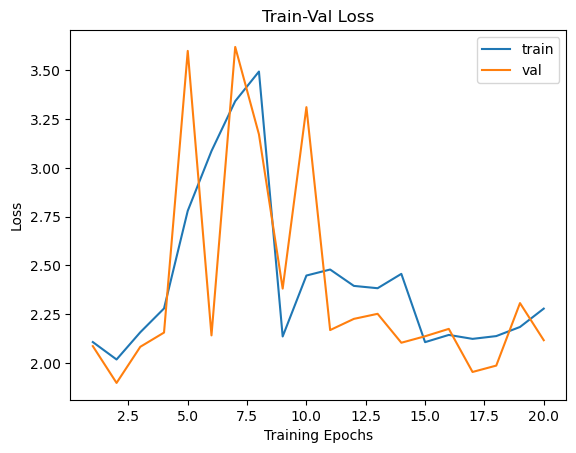

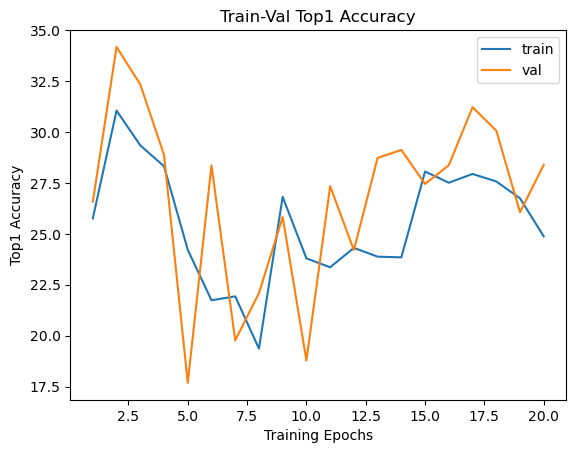

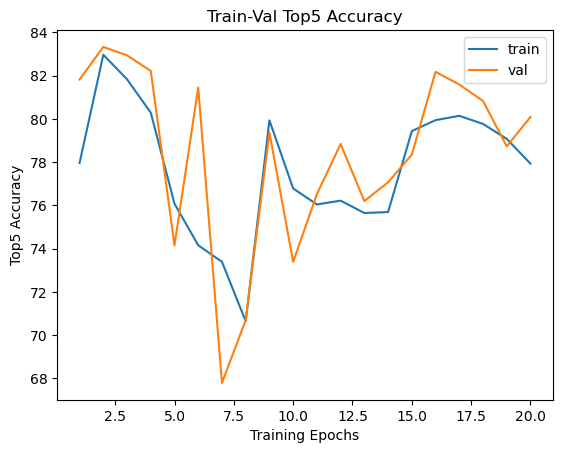

In [17]:
# pcresnet_256
# batch_size 32
# infer 횟수 25

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [13]:
# pcsimplenet_256
# batch_size 32
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-25 17:44:59
--------------------------------------------------
2023-10-25 17:44:59
Epoch 0/24, current lr = 0.01
==>> len_data: 50000
train loss: 1.70325522, train accuracy: (top1: 41.77%, top5: 84.90%)
elapsed time: 0:02:33
==>> len_data: 10000
val loss: 1.79619757, val accuracy: (top1: 41.33%, top5: 78.11%)
elapsed time: 0:00:02
 epoch elapsed time = 0:02:35
==>> total_num_epochs: 6
--------------------------------------------------
2023-10-25 17:47:34
Epoch 1/24, current lr = 0.01
==>> len_data: 50000
train loss: 1.75496933, train accuracy: (top1: 41.47%, top5: 80.90%)
elapsed time: 0:02:26
==>> len_data: 10000
val loss: 1.88022117, val accuracy: (top1: 39.06%, top5: 74.68%)
elapsed time: 0:00:02
 epoch elapsed time = 0:02:28
==>> total_num_epochs: 7
--------------------------------------------------
2023-10-25 17:50:03
Epoch 2/24, current lr = 0.01
==>> len_data: 50000
train loss: 1.87299553, train accuracy: (top1: 38.35%, top5: 75.52%)
elapsed time: 0:02:30
==>> len_data: 

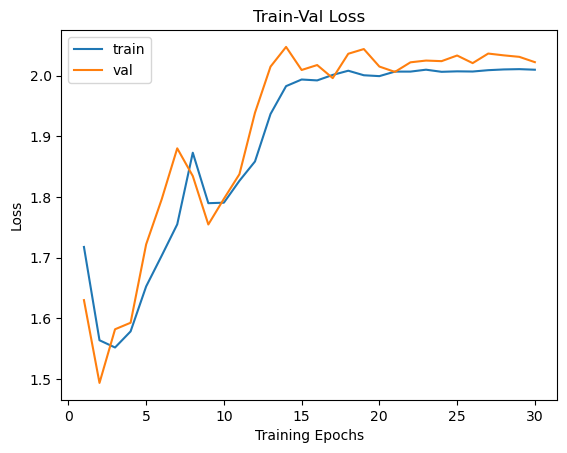

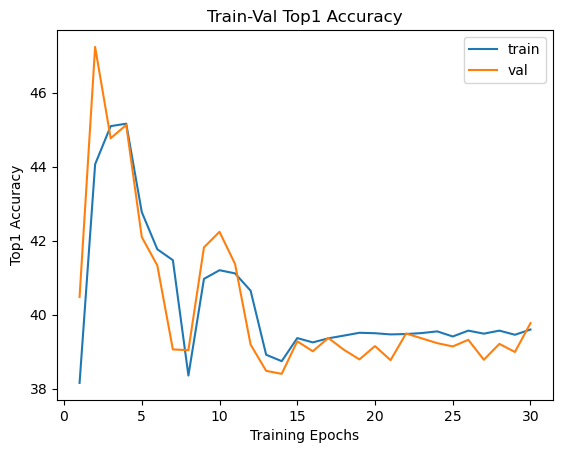

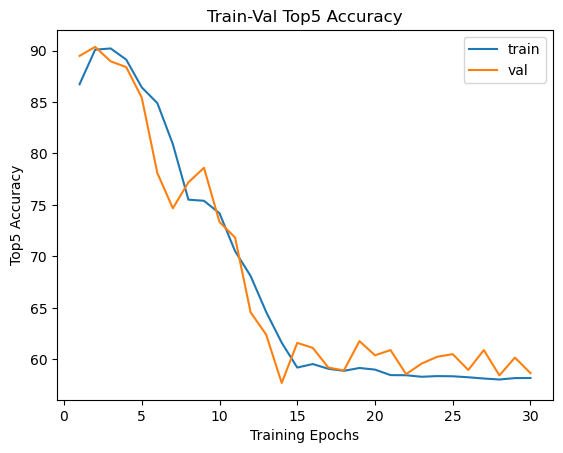

In [14]:
# pcsimplenet_256
# batch_size 32
# infer 횟수 25

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [15]:
# pcsimplenet_256
# batch_size 32
# infer 횟수 25

trained_model, loss_hist, acc_hist, time_hist, total_num_epochs = train_and_val(model=model, params=params_train)

2023-10-25 17:27:58
--------------------------------------------------
2023-10-25 17:27:58
Epoch 0/4, current lr = 0.01
==>> len_data: 50000


train loss: 1.71766257, train accuracy: (top1: 38.15%, top5: 86.73%)
elapsed time: 0:02:34
==>> len_data: 10000
val loss: 1.63004225, val accuracy: (top1: 40.48%, top5: 89.48%)
elapsed time: 0:00:02
 epoch elapsed time = 0:02:37
==>> total_num_epochs: 1
--------------------------------------------------
2023-10-25 17:30:35
Epoch 1/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.56388092, train accuracy: (top1: 44.07%, top5: 90.08%)
elapsed time: 0:02:30
==>> len_data: 10000
val loss: 1.49353491, val accuracy: (top1: 47.24%, top5: 90.35%)
elapsed time: 0:00:02
 epoch elapsed time = 0:02:32
==>> total_num_epochs: 2
--------------------------------------------------
2023-10-25 17:33:08
Epoch 2/4, current lr = 0.01
==>> len_data: 50000
train loss: 1.551911, train accuracy: (top1: 45.10%, top5: 90.20%)
elapsed time: 0:02:29
==>> len_data: 10000
val loss: 1.58197935, val accuracy: (top1: 44.77%, top5: 88.95%)
elapsed time: 0:00:02
 epoch elapsed time = 0:02:31
==>> total_num_epochs: 

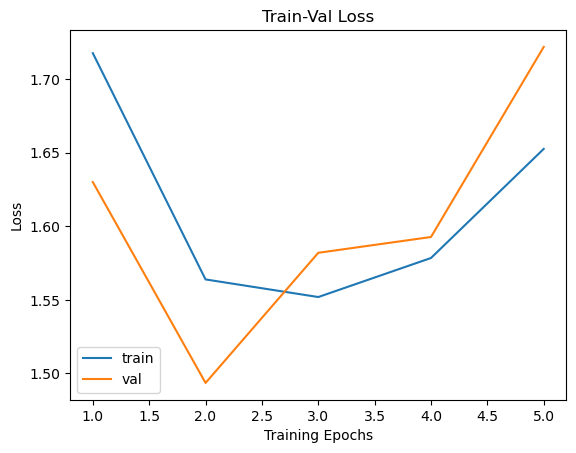

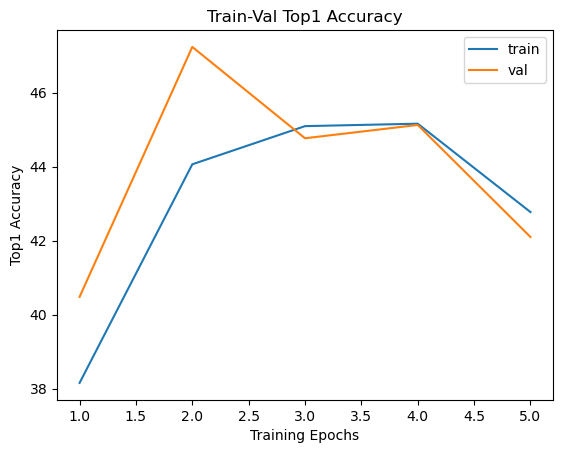

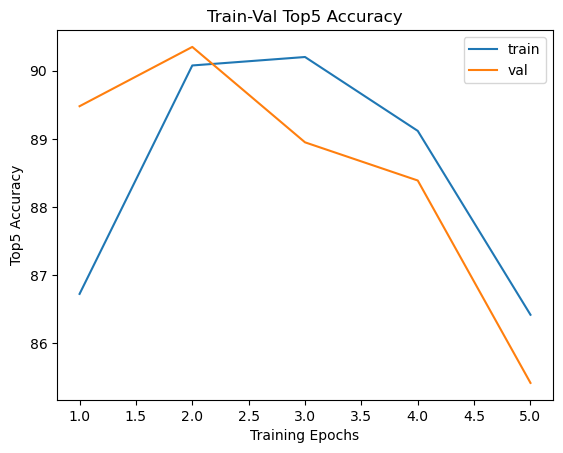

In [16]:
# pcsimplenet_256
# batch_size 32
# infer 횟수 25

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,total_num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,total_num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top1 accuracy progress
plt.title("Train-Val Top1 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top1"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top1"],label="val")
plt.ylabel("Top1 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot top5 accuracy progress
plt.title("Train-Val Top5 Accuracy")
plt.plot(range(1,total_num_epochs+1),acc_hist["train_top5"],label="train")
plt.plot(range(1,total_num_epochs+1),acc_hist["val_top5"],label="val")
plt.ylabel("Top5 Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()